###  steps to prepare dataset ready for consumption by model
* script :     reads two files and writes one consolidated movie dataset filtering unwanted columns 
* features/movie_plot (X): script generates movie plot "text" cleaned up of stop words and punctuations
* labels/genres:    script generates hot-multicoded "genre" for all movies filtering unlabeled movies

#### 1. download_movie_file(movie_file)
#### 2. download_plot_file(plot_file)
#### 3. create_dataset()
#### 4. hot_multicode_labels()
#### 5. filter_unlabeled_data(df_dataset)
#### 6. save_reload_dataset()
#### 7. Analyze data - for setting hyper parms: top_genres, sequence_len and predicted max label count per movie

The final output is a movie_dataset file containing following info:
The downloaded movie.metadata.csv file has nine (9) columns of which we need only 
movie_id, movie_name, genre that serve as Y_output labels and vectorized text sequence, one column per word.
Only top 8 out of 361 possible genres are selected to minimize data skewing
The labels are hot multicoded in the saved dataset along with vectorized values of movie_plot text sequence

Plot file which merged in to final dataset contains movie plot "text" which serves as X_input.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import json
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt 
import seaborn as sns


In [2]:
movie_metadata_file = './data/movie.metadata.tsv'
movie_plot_file = './data/plot_summaries.txt'
dataset_file = './data/movie_dataset.csv'

In [3]:
VOCAB_WORDLIMIT = 20000
SEQUENCE_LEN = 2000

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

top_genre = ['Drama', 'Comedy', 'Romance Film', 'Thriller', 'Action', 'World cinema', 'Crime Fiction', 'Horror']


In [4]:
def clean_text(text):
 text = BeautifulSoup(text, "lxml").text
 text = text.lower() # lowercase text
 text = REPLACE_BY_SPACE_RE.sub(' ', text)
 text = BAD_SYMBOLS_RE.sub('', text)
 text = ' '.join(word for word in text.split() if word not in STOPWORDS)
 return text

In [5]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [6]:
def download_metadata(movie_metadata_file):
    df_metadata = pd.read_csv(movie_metadata_file, engine='python', sep = '\t', header = None,
                     quotechar='"', error_bad_lines=False, warn_bad_lines=False)
    df_metadata.info()
    return df_metadata

In [7]:
df_metadata = download_metadata(movie_metadata_file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81735 entries, 0 to 81734
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       81735 non-null  int64  
 1   1       81735 non-null  object 
 2   2       81735 non-null  object 
 3   3       74833 non-null  object 
 4   4       8401 non-null   float64
 5   5       61287 non-null  float64
 6   6       81735 non-null  object 
 7   7       81735 non-null  object 
 8   8       81735 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


In [8]:
def download_plot(movie_plot_file):
    df_plot = pd.read_csv(movie_plot_file, engine='python', sep = '\t', header = None,
                     quotechar='"', error_bad_lines=False, warn_bad_lines=False)
    df_plot.info()
    return df_plot

In [9]:
df_plot = download_plot(movie_plot_file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42171 entries, 0 to 42170
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       42171 non-null  int64 
 1   1       42171 non-null  object
dtypes: int64(1), object(1)
memory usage: 659.0+ KB


In [10]:
def merge_plot_and_metadata():
    
    df_metadata.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]
    df_plot.columns = ["movie_id", "plot"]
    
    df_metadata_sub = df_metadata[["movie_id","movie_name","genre"]]
    df_metadata_sub = df_metadata_sub[["movie_id","movie_name","genre"]]
    df_metadata_sub['movie_id'] = df_metadata_sub['movie_id'].astype(str)

    df_plot['movie_id'] = df_plot['movie_id'].astype(str)
    df_dataset = pd.merge(df_plot, df_metadata_sub, on = 'movie_id')
    return df_dataset


In [11]:
df_dataset = merge_plot_and_metadata()

In [12]:
df_dataset

,movie_id,plot,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci..."
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
...,...,...,...,...
42066,34808485,"The story is about Reema , a young Muslim scho...",Oomakkuyil Padumbol,"{""/m/0bj8m2"": ""Children's""}"
42067,1096473,"In 1928 Hollywood, director Leo Andreyev look...",The Last Command,"{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi..."
42068,35102018,American Luthier focuses on Randy Parsons’ tra...,Randy Parsons: American Luthier,"{""/m/02hmvc"": ""Short Film"", ""/m/04rlf"": ""Music..."
42069,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",Kabuliwala,"{""/m/07s9rl0"": ""Drama""}"


In [13]:
def select_top_genre():
    genre_list = []
    for i in df_dataset['genre']:
        gen_filtered = []
        gen = json.loads(i).values()
        [gen_filtered.append(j) for j in list(gen) if j in top_genre]
        genre_list.append(gen_filtered)
    df_dataset['genre'] = genre_list

    return df_dataset

In [14]:
df_dataset = select_top_genre()

In [15]:
df_dataset

,movie_id,plot,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"[Drama, World cinema]"
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"[Action, Drama]"
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"[Action, Drama]"
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,[Comedy]
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"[Crime Fiction, Drama, World cinema]"
...,...,...,...,...
42066,34808485,"The story is about Reema , a young Muslim scho...",Oomakkuyil Padumbol,[]
42067,1096473,"In 1928 Hollywood, director Leo Andreyev look...",The Last Command,[Drama]
42068,35102018,American Luthier focuses on Randy Parsons’ tra...,Randy Parsons: American Luthier,[]
42069,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",Kabuliwala,[Drama]


In [16]:
def clean_stem_plot_text():
    df_dataset['plot'] = df_dataset['plot'].apply(clean_text)
    df_dataset['plot'] = df_dataset['plot'].apply(stemming)
    return df_dataset


In [17]:
df_dataset = clean_stem_plot_text()

In [18]:
df_dataset

,movie_id,plot,movie_name,genre
0,23890098,shlykov hardwork taxi driver lyosha saxophonis...,Taxi Blues,"[Drama, World cinema]"
1,31186339,nation panem consist wealthi capitol twelv poo...,The Hunger Games,"[Action, Drama]"
2,20663735,pooval induchoodan sentenc six year prison lif...,Narasimham,"[Action, Drama]"
3,2231378,lemon drop kid new york citi swindler illeg to...,The Lemon Drop Kid,[Comedy]
4,595909,seventhday adventist church pastor michael cha...,A Cry in the Dark,"[Crime Fiction, Drama, World cinema]"
...,...,...,...,...
42066,34808485,stori reema young muslim schoolgirl malabar lo...,Oomakkuyil Padumbol,[]
42067,1096473,1928 hollywood director leo andreyev look phot...,The Last Command,[Drama]
42068,35102018,american luthier focus randi parson transform ...,Randy Parsons: American Luthier,[]
42069,8628195,abdur rehman khan middleag dri fruit seller af...,Kabuliwala,[Drama]


In [19]:
def vectorize_plot(df):
    df['plot'] = df['plot'].astype(str)
    tokenizer = Tokenizer(num_words=VOCAB_WORDLIMIT,
                          filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(df_dataset['plot'].values)
    plot_vocab = tokenizer.word_index
    print("plot_vocab: {}, len(plot_vocab): {}, size limited to: {}".format(
        type(plot_vocab), len(plot_vocab),VOCAB_WORDLIMIT))

    plot_str_val = tokenizer.texts_to_sequences(df_dataset['plot'].values)
    plot_str_val = pad_sequences(plot_str_val, maxlen=SEQUENCE_LEN)
    
    X_plot = [plot_str_val[i] for i in range(plot_str_val.shape[0])]
    print('X_plot:', type(X_plot), len(X_plot))
    return X_plot, plot_vocab

In [20]:
X_plot, plot_vocab = vectorize_plot(df_dataset)


plot_vocab: <class 'dict'>, len(plot_vocab): 134441, size limited to: 20000
X_plot: <class 'list'> 42071


In [21]:
def add_X_plot_to_dataset(df):
    df_X_plot = pd.DataFrame(X_plot)
    df = df.join(df_X_plot)
    return(df)

In [22]:
df_dataset = add_X_plot_to_dataset(df_dataset)

In [23]:
df_dataset

,movie_id,plot,movie_name,genre,0,1,2,3,4,5,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,23890098,shlykov hardwork taxi driver lyosha saxophonis...,Taxi Blues,"[Drama, World cinema]",0,0,0,0,0,0,...,580,19098,418,2748,151,236,5965,95,4254,409
1,31186339,nation panem consist wealthi capitol twelv poo...,The Hunger Games,"[Action, Drama]",0,0,0,0,0,0,...,2710,4255,583,107,2047,6504,637,1333,856,439
2,20663735,pooval induchoodan sentenc six year prison lif...,Narasimham,"[Action, Drama]",0,0,0,0,0,0,...,12131,65,7,840,26,17531,215,9835,26,567
3,2231378,lemon drop kid new york citi swindler illeg to...,The Lemon Drop Kid,[Comedy],0,0,0,0,0,0,...,328,34,5078,130,591,321,3835,10640,659,60
4,595909,seventhday adventist church pastor michael cha...,A Cry in the Dark,"[Crime Fiction, Drama, World cinema]",0,0,0,0,0,0,...,837,219,386,283,172,318,4963,1314,7255,6618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42066,34808485,stori reema young muslim schoolgirl malabar lo...,Oomakkuyil Padumbol,[],0,0,0,0,0,0,...,10,827,4650,129,1011,6716,92,159,921,2297
42067,1096473,1928 hollywood director leo andreyev look phot...,The Last Command,[Drama],0,0,0,0,0,0,...,1989,672,412,944,1672,1096,412,944,412,18
42068,35102018,american luthier focus randi parson transform ...,Randy Parsons: American Luthier,[],0,0,0,0,0,0,...,99,1709,4,303,94,265,1,409,65,17852
42069,8628195,abdur rehman khan middleag dri fruit seller af...,Kabuliwala,[Drama],0,0,0,0,0,0,...,186,1050,17600,74,10,29,17600,204,7,5395


In [24]:
def hot_multicode_labels(df, start_col=4+SEQUENCE_LEN):
    mlb = MultiLabelBinarizer()
    mlb.fit_transform(df['genre'])
    Y_genre = mlb.transform(df['genre'])

    print('hot multicoded Y_genre ->', type(Y_genre), Y_genre.shape)

    for idx, genre in enumerate(mlb.classes_):
      df[genre] = Y_genre[:,idx]

    Y_genre_col_name = df.columns.tolist()[start_col::]

    assert (len(Y_genre[1])==len(Y_genre_col_name)), "num of genre labels do not match with hot enconded list"
    assert (len(Y_genre_col_name)==len(top_genre)), "inconsistent data -- not all top genres are properly processed"

    return


In [25]:
hot_multicode_labels(df_dataset)


hot multicoded Y_genre -> <class 'numpy.ndarray'> (42071, 8)


In [26]:
df_dataset

,movie_id,plot,movie_name,genre,0,1,2,3,4,5,...,1998,1999,Action,Comedy,Crime Fiction,Drama,Horror,Romance Film,Thriller,World cinema
0,23890098,shlykov hardwork taxi driver lyosha saxophonis...,Taxi Blues,"[Drama, World cinema]",0,0,0,0,0,0,...,4254,409,0,0,0,1,0,0,0,1
1,31186339,nation panem consist wealthi capitol twelv poo...,The Hunger Games,"[Action, Drama]",0,0,0,0,0,0,...,856,439,1,0,0,1,0,0,0,0
2,20663735,pooval induchoodan sentenc six year prison lif...,Narasimham,"[Action, Drama]",0,0,0,0,0,0,...,26,567,1,0,0,1,0,0,0,0
3,2231378,lemon drop kid new york citi swindler illeg to...,The Lemon Drop Kid,[Comedy],0,0,0,0,0,0,...,659,60,0,1,0,0,0,0,0,0
4,595909,seventhday adventist church pastor michael cha...,A Cry in the Dark,"[Crime Fiction, Drama, World cinema]",0,0,0,0,0,0,...,7255,6618,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42066,34808485,stori reema young muslim schoolgirl malabar lo...,Oomakkuyil Padumbol,[],0,0,0,0,0,0,...,921,2297,0,0,0,0,0,0,0,0
42067,1096473,1928 hollywood director leo andreyev look phot...,The Last Command,[Drama],0,0,0,0,0,0,...,412,18,0,0,0,1,0,0,0,0
42068,35102018,american luthier focus randi parson transform ...,Randy Parsons: American Luthier,[],0,0,0,0,0,0,...,65,17852,0,0,0,0,0,0,0,0
42069,8628195,abdur rehman khan middleag dri fruit seller af...,Kabuliwala,[Drama],0,0,0,0,0,0,...,7,5395,0,0,0,1,0,0,0,0


In [27]:
def filter_unlabeled_data(df, start_col_index=df_dataset.columns.get_loc("Action")):
    df_bool = (df[df.columns[start_col_index::]] != 0).any(axis=1)
    df_filtered = df.loc[df_bool]
    print("len of filtered dataset {}, number of rows filtered out {}:".format(
        len(df_filtered), len(df)-len(df_filtered)))
    return df_filtered


In [28]:
df_dataset = filter_unlabeled_data(df_dataset)

len of filtered dataset 34561, number of rows filtered out 7510:


In [29]:
def save_reload_dataset():
    df_dataset.to_csv(dataset_file, index=False )
    df_new = pd.read_csv(dataset_file)
    print("total movies saved:", len(df_new))
    return df_new

In [30]:
df_dataset = save_reload_dataset()

total movies saved: 34561


In [31]:
df_dataset

,movie_id,plot,movie_name,genre,0,1,2,3,4,5,...,1998,1999,Action,Comedy,Crime Fiction,Drama,Horror,Romance Film,Thriller,World cinema
0,23890098,shlykov hardwork taxi driver lyosha saxophonis...,Taxi Blues,"['Drama', 'World cinema']",0,0,0,0,0,0,...,4254,409,0,0,0,1,0,0,0,1
1,31186339,nation panem consist wealthi capitol twelv poo...,The Hunger Games,"['Action', 'Drama']",0,0,0,0,0,0,...,856,439,1,0,0,1,0,0,0,0
2,20663735,pooval induchoodan sentenc six year prison lif...,Narasimham,"['Action', 'Drama']",0,0,0,0,0,0,...,26,567,1,0,0,1,0,0,0,0
3,2231378,lemon drop kid new york citi swindler illeg to...,The Lemon Drop Kid,['Comedy'],0,0,0,0,0,0,...,659,60,0,1,0,0,0,0,0,0
4,595909,seventhday adventist church pastor michael cha...,A Cry in the Dark,"['Crime Fiction', 'Drama', 'World cinema']",0,0,0,0,0,0,...,7255,6618,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34556,30352708,twentysometh eunmo listen taxi driver drone ri...,Paju,"['Romance Film', 'Drama', 'World cinema']",0,0,0,0,0,0,...,738,1080,0,0,0,1,0,1,0,1
34557,2867597,attempt bring fame mr bill clay charact life s...,Mr. Bill's Real Life Adventures,['Comedy'],0,0,0,0,0,0,...,600,766,0,1,0,0,0,0,0,0
34558,1096473,1928 hollywood director leo andreyev look phot...,The Last Command,['Drama'],0,0,0,0,0,0,...,412,18,0,0,0,1,0,0,0,0
34559,8628195,abdur rehman khan middleag dri fruit seller af...,Kabuliwala,['Drama'],0,0,0,0,0,0,...,7,5395,0,0,0,1,0,0,0,0


In [32]:
def print_genre_freq(df, start_col_idx=4+SEQUENCE_LEN):
    
    df = df[df.columns[start_col_idx::]]
    df = df.apply(pd.value_counts)
    df = df[1:2]
    df = df.sort_values(by =1,axis=1, ascending=False)
    df = df.transpose()
    sum_all = df.sum(axis = 0, skipna = True)
    print("genre freq for {} movies".format(len(df_dataset)))
    print(df)
    print(" total_col", sum_all)
    
    return df


In [33]:
df_genre_freq = print_genre_freq(df_dataset)

genre freq for 34561 movies
                   1
Drama          19076
Comedy         10429
Romance Film    6649
Thriller        6508
Action          5853
World cinema    5145
Crime Fiction   4261
Horror          4072
 total_col 1    61993
dtype: int64


In [34]:
def render_genre_freq(df):
    plt.figure(figsize=(12,6))
    ax = sns.barplot(data=df, x = list(df.index), y =df.iloc[:,0])
    ax.set(ylabel = "Movie Count", xlabel = "Genre")
    plt.show()
    return


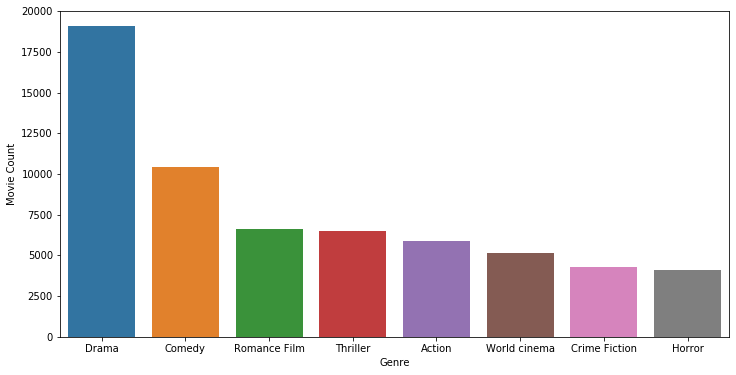

In [35]:
render_genre_freq(df_genre_freq)

In [36]:
def freq_labels_per_movie(df):
    label_count = []
    label_freq_array = []
    [label_count.append(row.count(',')+1) for row in df['genre']]
    [label_freq_array.append(label_count.count(i+1)) for i in range(len(top_genre))]
    return label_freq_array


In [37]:
def render_labelcount_freq(df):
    label_freq_array = freq_labels_per_movie(df_dataset)
    plt.figure(figsize=(12,6))
    ax = sns.barplot(data=df, x = [1,2,3,4,5,6,7,8], y =label_freq_array)
    ax.set(ylabel = "lebel Frequency", xlabel = "label Count")
    plt.show()

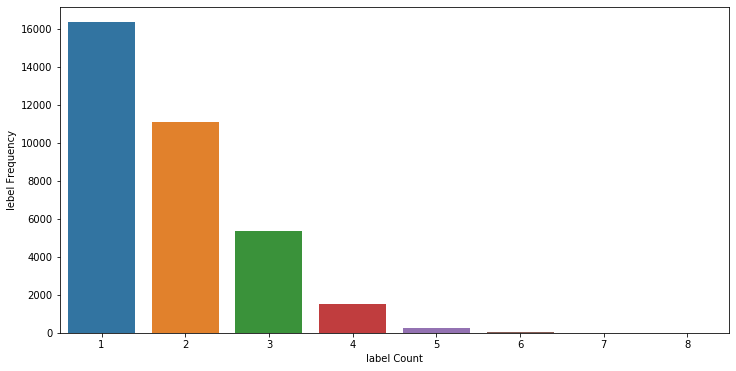

In [38]:
render_labelcount_freq(df_dataset)

In [39]:
def unique_plotsize_counts(df):
    plot_size_array = []
    plot_size_array = [len(str(df["plot"][i])) for i in range(df["plot"].shape[0])]
    plot_size_array.sort()

    plot_size_array_unique = set(plot_size_array)
    plot_size_array_unique = list(plot_size_array_unique)
    print("Number of unique plots count:", len(plot_size_array_unique))
    return plot_size_array_unique


In [40]:
plot_size_array_unique = unique_plotsize_counts(df_dataset)


Number of unique plots count: 4203


In [41]:
def unique_plotsize_freq(df):
    xarr = [0, 1000,2000,3000,4000,5000,6000,7000,8000]
    yarr = [0, 0, 0, 0, 0, 0, 0, 0, 0]

    for i, ps in enumerate(plot_size_array_unique):
        for j in range(len(xarr)):
            if (ps>=xarr[j] and xarr[j]+1000) :
                yarr[j] = yarr[j]+1
            else:
                continue
    return xarr, yarr

In [42]:
def render_plotsize_freq(df):
    xarr, yarr = unique_plotsize_freq(df_dataset)
    plt.figure(figsize=(12,6))
    ax = sns.barplot(data=df, x = xarr, y = yarr)
    ax.set(ylabel = "NUMBER OF MOVIES",
           xlabel = "MOVIE PLOT SIZE HISTOGRAM in intervals of 1000's")
    plt.show()

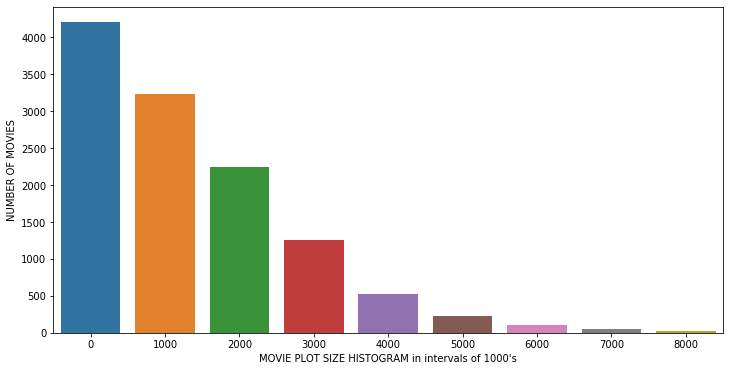

In [43]:
render_plotsize_freq(df_dataset)